# Deep Drilling Field observing strategy

In [1]:
# Import required python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3
from astropy.coordinates import SkyCoord
import astropy.units as u
import rubin_scheduler.scheduler.utils as sched_utils
from rubin_scheduler.utils import ddf_locations, ddf_locations_skycoord
from rubin_sim.data import get_baseline
import rubin_sim.maf as maf

In [3]:
# v4.3.1 runs
summaries = maf.get_metric_summaries(summary_source='summary.h5')
print(f"This summary h5 file contains information on {len(summaries.index)} simulations.")
print(summaries.index)

This summary h5 file contains information on 34 simulations.
Index(['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
       'baseline_v3.0_10yrs', 'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs',
       'baseline_v3.4_10yrs', 'baseline_v3.5_10yrs', 'baseline_v3.6_10yrs',
       'baseline_v4.0_10yrs', 'baseline_v4.1_10yrs', 'baseline_v4.2_10yrs',
       'baseline_v4.3.1_10yrs', 'desc_v4.3.1_10yrs', 'one_snap_v4.3.1_10yrs',
       'retro_baseline_v2.0_10yrs', 'start_date_mjdp180_v4.3.1_10yrs',
       'start_date_mjdp270_v4.3.1_10yrs', 'start_date_mjdp360_v4.3.1_10yrs',
       'start_date_mjdp90_v4.3.1_10yrs', 'weather_cloudso0v4.3.1_10yrs',
       'weather_cloudso10v4.3.1_10yrs', 'weather_cloudso12v4.3.1_10yrs',
       'weather_cloudso16v4.3.1_10yrs', 'weather_cloudso18v4.3.1_10yrs',
       'weather_cloudso1v4.3.1_10yrs', 'weather_cloudso20v4.3.1_10yrs',
       'weather_cloudso2v4.3.1_10yrs', 'weather_cloudso30v4.3.1_10yrs',
       'weather_cloudso31v4.3.1_10yrs', 'weath

In [4]:
metric_subsets = maf.get_metric_subsets('metric_subsets.json')
msets = list(metric_subsets.groupby('metric subset').first().index)
# DDF specific metrics
[m for m in msets if 'DDF' in m]

['AGN SF DDF',
 'AGN TimeLag 100 days DDF',
 'AGN TimeLag 5 days DDF',
 'DDF Cadence',
 'DDF Depths',
 'SNIa DDF',
 'SNSL DDF']

In [15]:
m5_SRD_design = {'u': 23.90, 'g': 25.00, 'r': 24.70, 'i': 24.00, 'z': 23.30, 'y': 22.10}
m5_SRD_minimum = {'u': 23.40, 'g':24.60, 'r': 24.30, 'i': 23.60, 'z': 22.90, 'y': 21.70}

# Weather variations on baseline strategy
weather_runs = [r for r in summaries.index if 'weather' in r]
offsets = [int(w.split('dso')[-1].split('v4')[0]) for w in weather_runs]
idx = np.argsort(offsets)
weather_runs = [weather_runs[i] for i in idx]
print("weather runs", len(weather_runs))

# Start date variations
start_dates = [r for r in summaries.index if 'start_date' in r]
offsets = [int(r.split('mjdp')[-1].split('_')[0]) for r in start_dates]
idx = np.argsort(offsets)
start_dates = [start_dates[i] for i in idx]
print("start_dates", len(start_dates))


# Baseline sims, and put them in order of evolution

baseline_dict = {'retro_baseline_v2.0_10yrs': 'v1.x', 
                 'baseline_v2.0_10yrs':'v2.0', 
                 'baseline_v2.1_10yrs':'v2.1',
                 'baseline_v2.2_10yrs':'v2.2',
                 'baseline_v3.0_10yrs':'v3.0',
                 'baseline_v3.2_10yrs':'v3.2',
                'baseline_v3.3_10yrs':'v3.3',
                'baseline_v3.4_10yrs': 'v3.4',
                'baseline_v3.5_10yrs': 'v3.5', 
                 'baseline_v3.6_10yrs': 'v3.6',
                 'baseline_v4.0_10yrs': 'v4.0',
                 'baseline_v4.1_10yrs': 'v4.1',
                 'baseline_v4.2_10yrs': 'v4.2'
                }

newbaselines_dict = {'baseline_v4.3_10yrs': "baseline v4.3",
                    'one_snap_v4.3_10yrs' : "single snap v4.3",
                    }

rdict = {}
for k in baseline_dict:
    rdict[k] = baseline_dict[k]
for k in newbaselines_dict:
    rdict[k] = newbaselines_dict[k]

runs = list(rdict.keys())
baselinerun = 'baseline_v4.3.1_10yrs'
baseline = baselinerun

ddf_runs = ['desc_v4.3.1_10yrs']
ddf_sets = [ddf_runs]

outdir = 'tmp_fig'
try:
    os.mkdir(outdir)
except:
    pass

weather runs 14
start_dates 4


### Deep drilling field observing strategy

The baseline run (baseline_v4.3.1) can be compared against the DESC-style DDF run (desc_ddf_v4.3.1).
The detailed MAF metrics for each simulation are available here - http://usdf-maf.slac.stanford.edu - with particular emphasis on the "DD metrics". 

The baseline survey strategy for the DDFs includes 5 DDF pointings, with varying number of visits per DDF:
* COSMOS attains 10 year DDF depth by year 3, and continues observations thus acquiring almost double the other pointings.
* Euclid Deep Field South (EDFS) is split into two different pointings (a, b) to match the Euclid field size, but share the total number of visits.
* A rough baseline number is that each DDF obtains about 21,000 visits over 10 years, corresponding to about 6% of the total (2.1M) visits.

After v4.1, the maximum extent DDF dithers is about 0.2 degrees

In [8]:
all_runs = ['baseline_v4.0_10yrs', 'baseline_v4.3.1_10yrs'] + ddf_runs
all_runs

['baseline_v4.0_10yrs', 'baseline_v4.3.1_10yrs', 'desc_v4.3.1_10yrs']

In [9]:
# Basic DDF information, number of visits from baseline simulation
ddfs = ddf_locations_skycoord()
nvis = {}
for run in ['baseline_v4.3.1_10yrs.db', 'desc_ddf_v4.3.1_10yrs.db']:
    conn = sqlite3.connect(run)
    r = run.rstrip(".db")
    nvis[r] = {}
    for i in ddfs:
        query = f"select count(*) from observations where scheduler_note like '%{i}%'"
        nvis[r][i] = int(pd.read_sql(query, conn).values[0][0])

pdfs = {}
for i in ddfs:
    ra = ddfs[i].ra.deg
    dec = ddfs[i].dec.deg
    coord = ddfs[i]
    ra_hours = coord.ra.hms
    eclip_lat = coord.barycentrictrueecliptic.lat.deg
    eclip_lon = coord.barycentrictrueecliptic.lon.deg
    gal_lon = coord.galactic.l.deg
    gal_lat = coord.galactic.b.deg
    pdfs[i] = [ra, dec, gal_lon, gal_lat, eclip_lon, eclip_lat]
d = pd.DataFrame(pdfs, index=['RA', 'Dec', 'Gal l', 'Gal b', 'Eclip l', 'Eclip b']).round(2)
n = pd.DataFrame(nvis).T
d = pd.concat([d, n])
d

,ELAISS1,XMM_LSS,ECDFS,COSMOS,EDFS_a,EDFS_b
RA,9.45,35.57,52.98,150.11,58.90,63.60
Dec,-44.02,-4.82,-28.12,2.23,-49.32,-47.60
Gal l,311.29,171.10,224.07,236.78,257.90,254.48
Gal b,-72.88,-58.91,-54.60,42.13,-48.46,-45.77
Eclip l,346.66,31.59,40.81,151.39,32.00,40.97
Eclip b,-43.20,-17.92,-45.44,-9.34,-66.61,-66.60
baseline_v4.3.1_10yrs,22769.00,23330.00,23712.00,45649.00,11824.00,11779.00
desc_ddf_v4.3.1_10yrs,6316.00,51954.00,6756.00,59990.00,3436.00,3436.00


In the baseline simulation, visits are acquired in sequences where a DDF is observed continuously in grizy or ugriz filters for approximately one hour. Complete sequences consist of 
* 8 u band visits (if u is available)
* 10 g band visits
* 20 r band visits
* 20 i band visits
* 24 z band visits
* 18 y band visits (if y is available)

## Very high level "wfd" scoc metrics

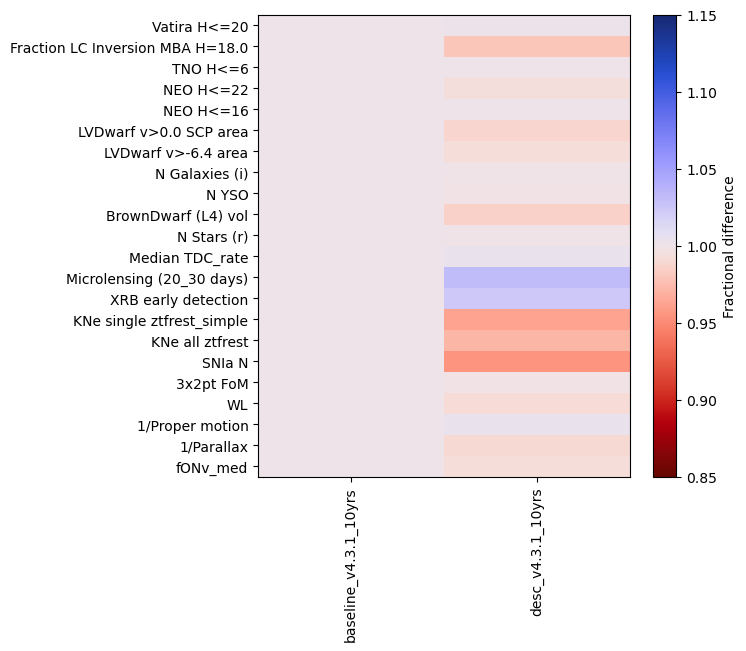

In [16]:
# What about the SCOC high-level overview? 

msub = metric_subsets.loc['SCOC']

fig, ax = maf.plot_run_metric_mesh(summaries.loc[[baseline]+ ddf_runs, msub['metric']], 
                     baseline_run=baseline,
                     metric_subset=msub,
                        metric_label_map=msub['short_name'],
                    color_range=0.3,
                      )

## Fraction of DDF time

Varying the DDF strategy can inadvertently change the overall number of DDF visits or the overall fraction of survey time devoted to DDF observations. Changes here can affect the overall metrics for the strategy, so is worth checking first to identify which runs could be considered the most "apples to apples". 

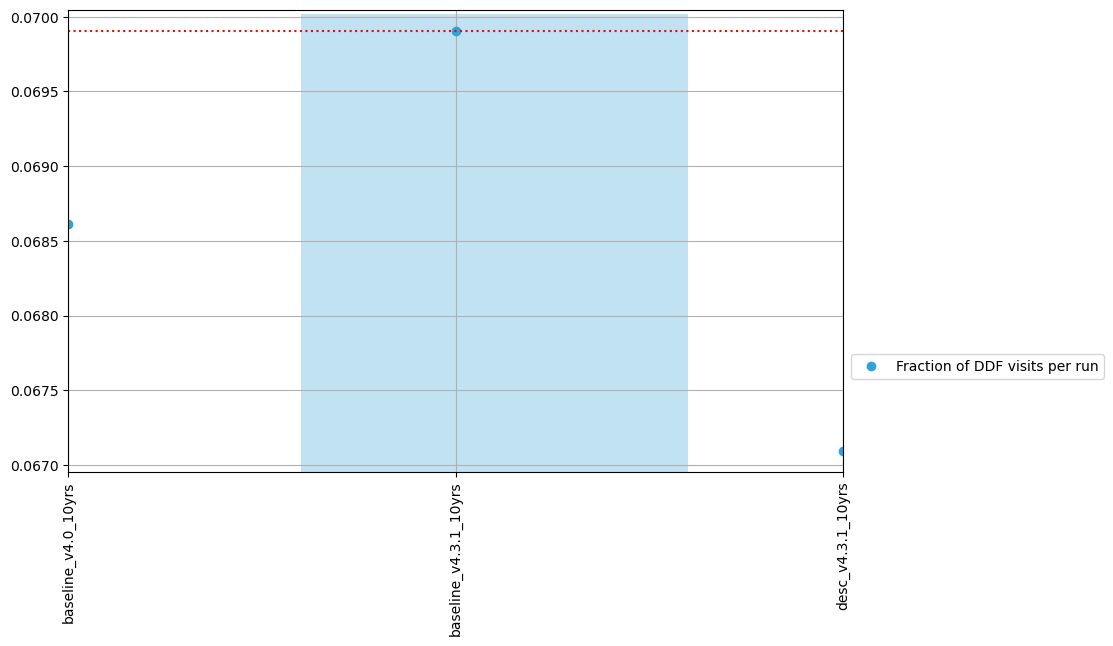

In [17]:
visits = ['Identity Nvisits All visits UniSlicer', 'Identity Nvisits DDF UniSlicer']
fraction = pd.DataFrame(summaries.loc[all_runs, visits[1]] / summaries.loc[all_runs, visits[0]],
                       columns=["Fraction of DDF visits per run"])

fig, ax = maf.plot_run_metric(fraction, shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ax.axhline(fraction.loc[baselinerun].values, color='red', linestyle=':')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

The plot of fraction of DDF visits in each simulation shows that most of the simulations vary slightly around the 6% achieved in the baseline simulation (this is after repeating the ddf agn run, with adjustments). 

We can also double check on the end of survey coadded depths for each DDF in each filter -- in general, we'd expect them to track with the trends above: 

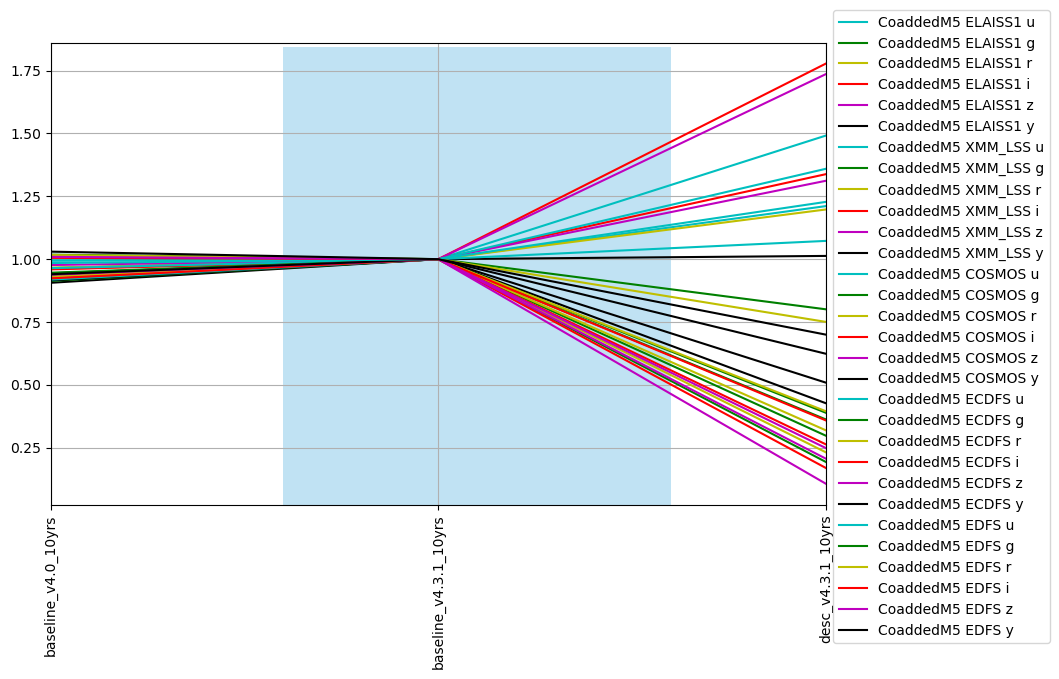

In [18]:
msub = metric_subsets.loc['DDF Depths'].query("not metric.str.contains('WFD') and metric.str.contains('Coadd')")
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, -0.3))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

In [19]:
summaries.loc[all_runs, msub['metric']].round(2).T

run,baseline_v4.0_10yrs,baseline_v4.3.1_10yrs,desc_v4.3.1_10yrs
metric,,,
Median DD:ELAISS1 CoaddM5 u band HealpixSubsetSlicer,26.84,26.85,27.06
Median DD:ELAISS1 CoaddM5 g band HealpixSubsetSlicer,28.31,28.34,27.54
Median DD:ELAISS1 CoaddM5 r band HealpixSubsetSlicer,28.30,28.33,27.57
Median DD:ELAISS1 CoaddM5 i band HealpixSubsetSlicer,27.92,27.98,27.15
Median DD:ELAISS1 CoaddM5 z band HealpixSubsetSlicer,27.40,27.46,26.57
Median DD:ELAISS1 CoaddM5 y band HealpixSubsetSlicer,26.04,26.13,25.56
Median DD:XMM_LSS CoaddM5 u band HealpixSubsetSlicer,26.74,26.75,27.24
Median DD:XMM_LSS CoaddM5 g band HealpixSubsetSlicer,28.20,28.26,28.06
Median DD:XMM_LSS CoaddM5 r band HealpixSubsetSlicer,28.21,28.25,28.45


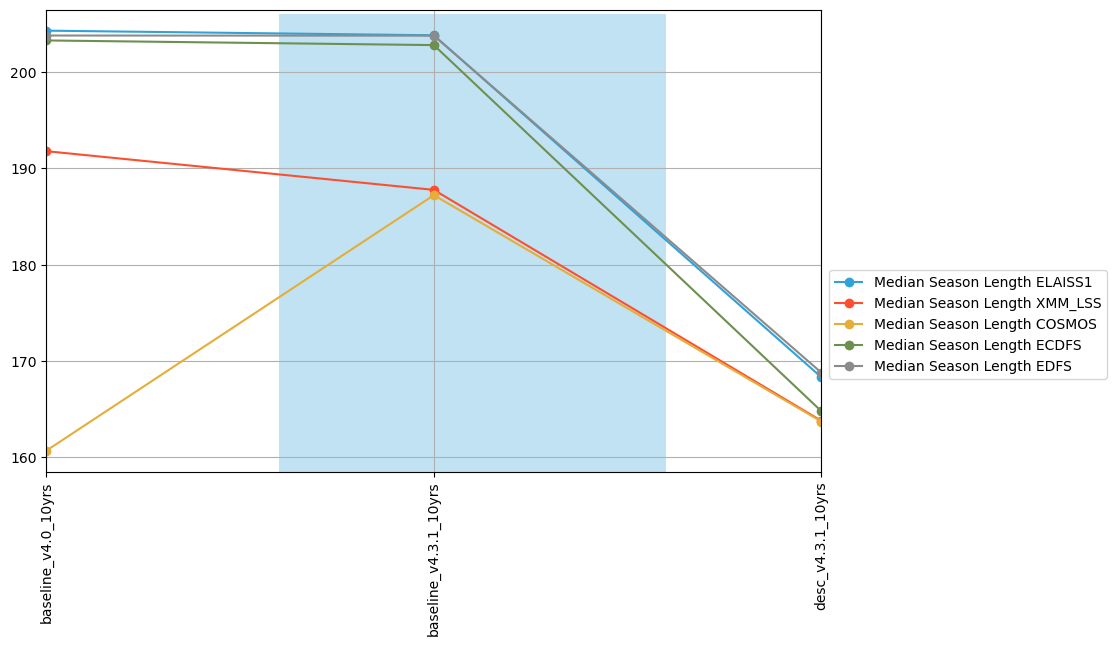

In [20]:
# Median season length (across all seasons)
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Season Length") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

Looking at the plot of median season length per DDF (median over all seasons) we see that the baseline simulation has typical season lengths of about 200 days, which we saw varied more dramatically through the v3.4 'accordian' series.

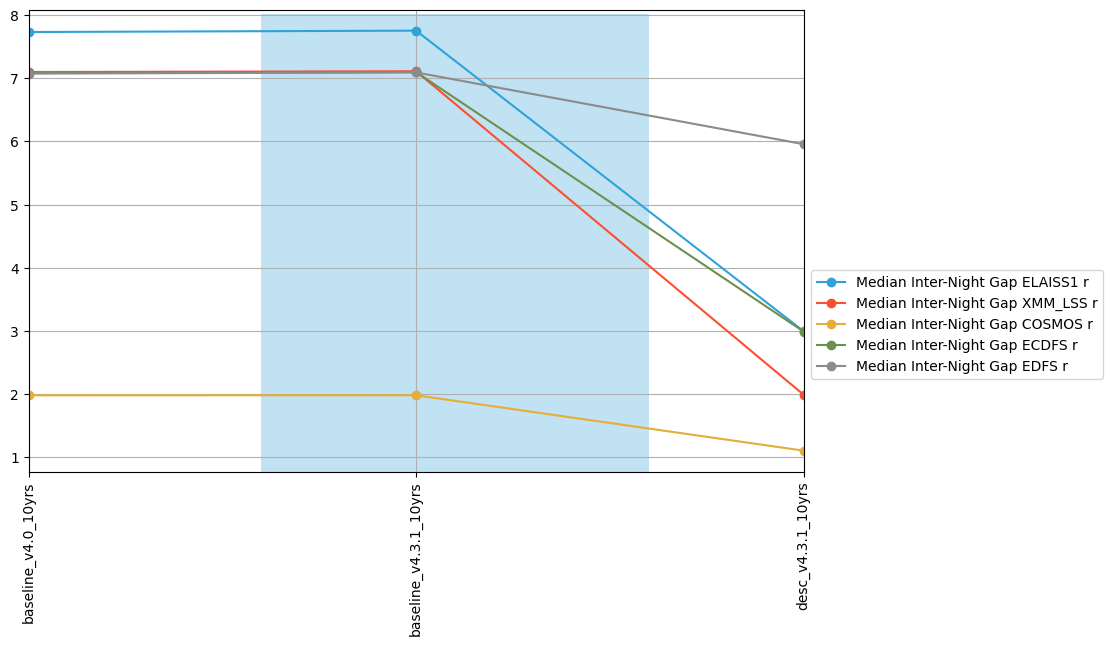

In [21]:
# Median inter-night gap in r band; i and z band similar trends
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Gap r") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

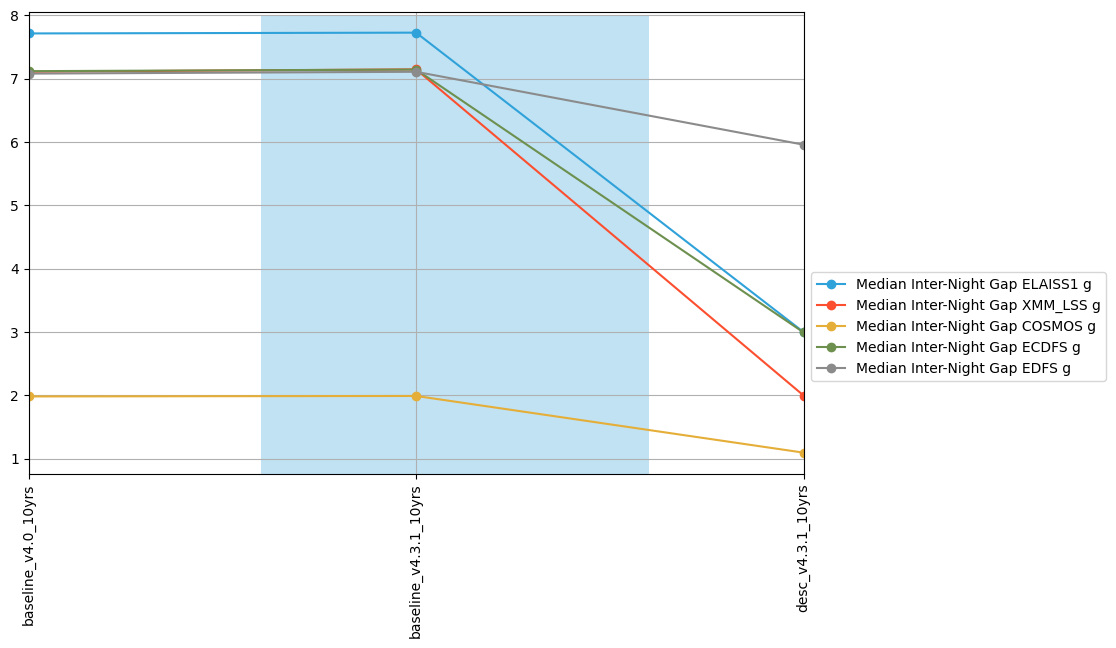

In [22]:
msub = metric_subsets.loc['DDF Cadence'].query('metric.str.contains("Gap g") and not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

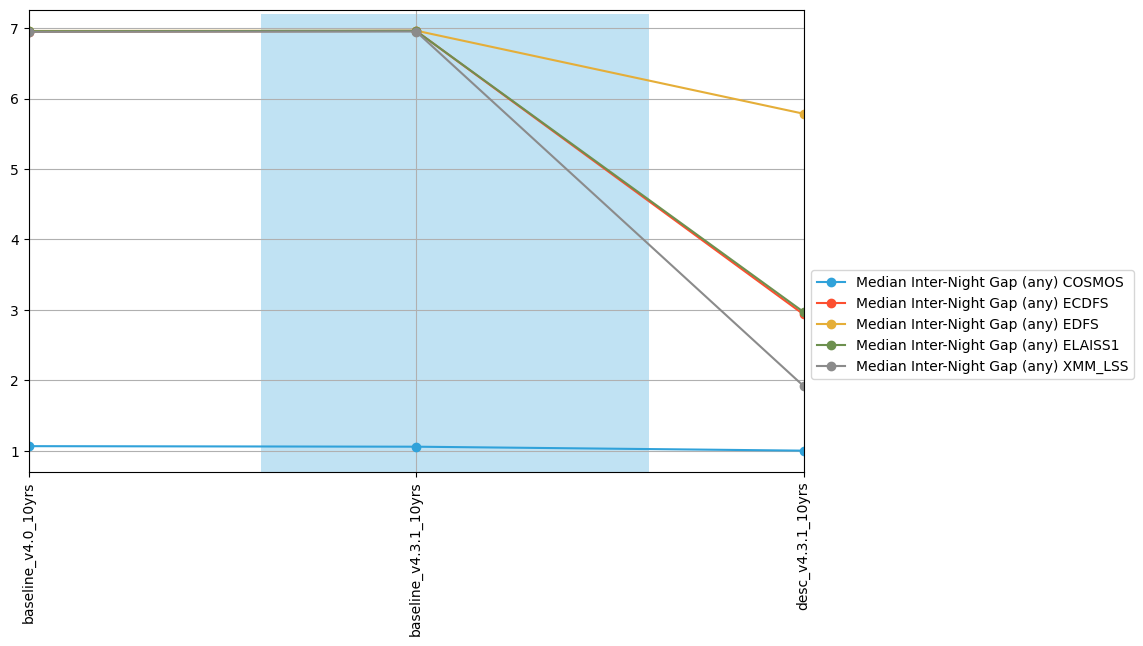

In [23]:
metric = [m for m in summaries if 'DD:' in m and 'Median Inter-Night Gap all bands' in m and 'WFD' not in m]
short_names = [f"Median Inter-Night Gap (any) {m.split('DD:')[1].split(' ')[0]}" for m in metric]
mapper = dict(zip(metric, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metric],
                              #metric_subset=msub,
                              metric_label_map=mapper,
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

 (It's worthwhile to note that these metrics are calculated based on gaps in *any* location in the DDF, because they are just evaluating the gaps between nights with DDF visits in that field .. the slicer is a "UniSlicer", not a "HealpixSubsetSlicer" which would consider which ra/dec value in particular is being observed .. the dither size should impact metrics evaluated with the HealpixSubsetSlicer but not the UniSlicer.). 

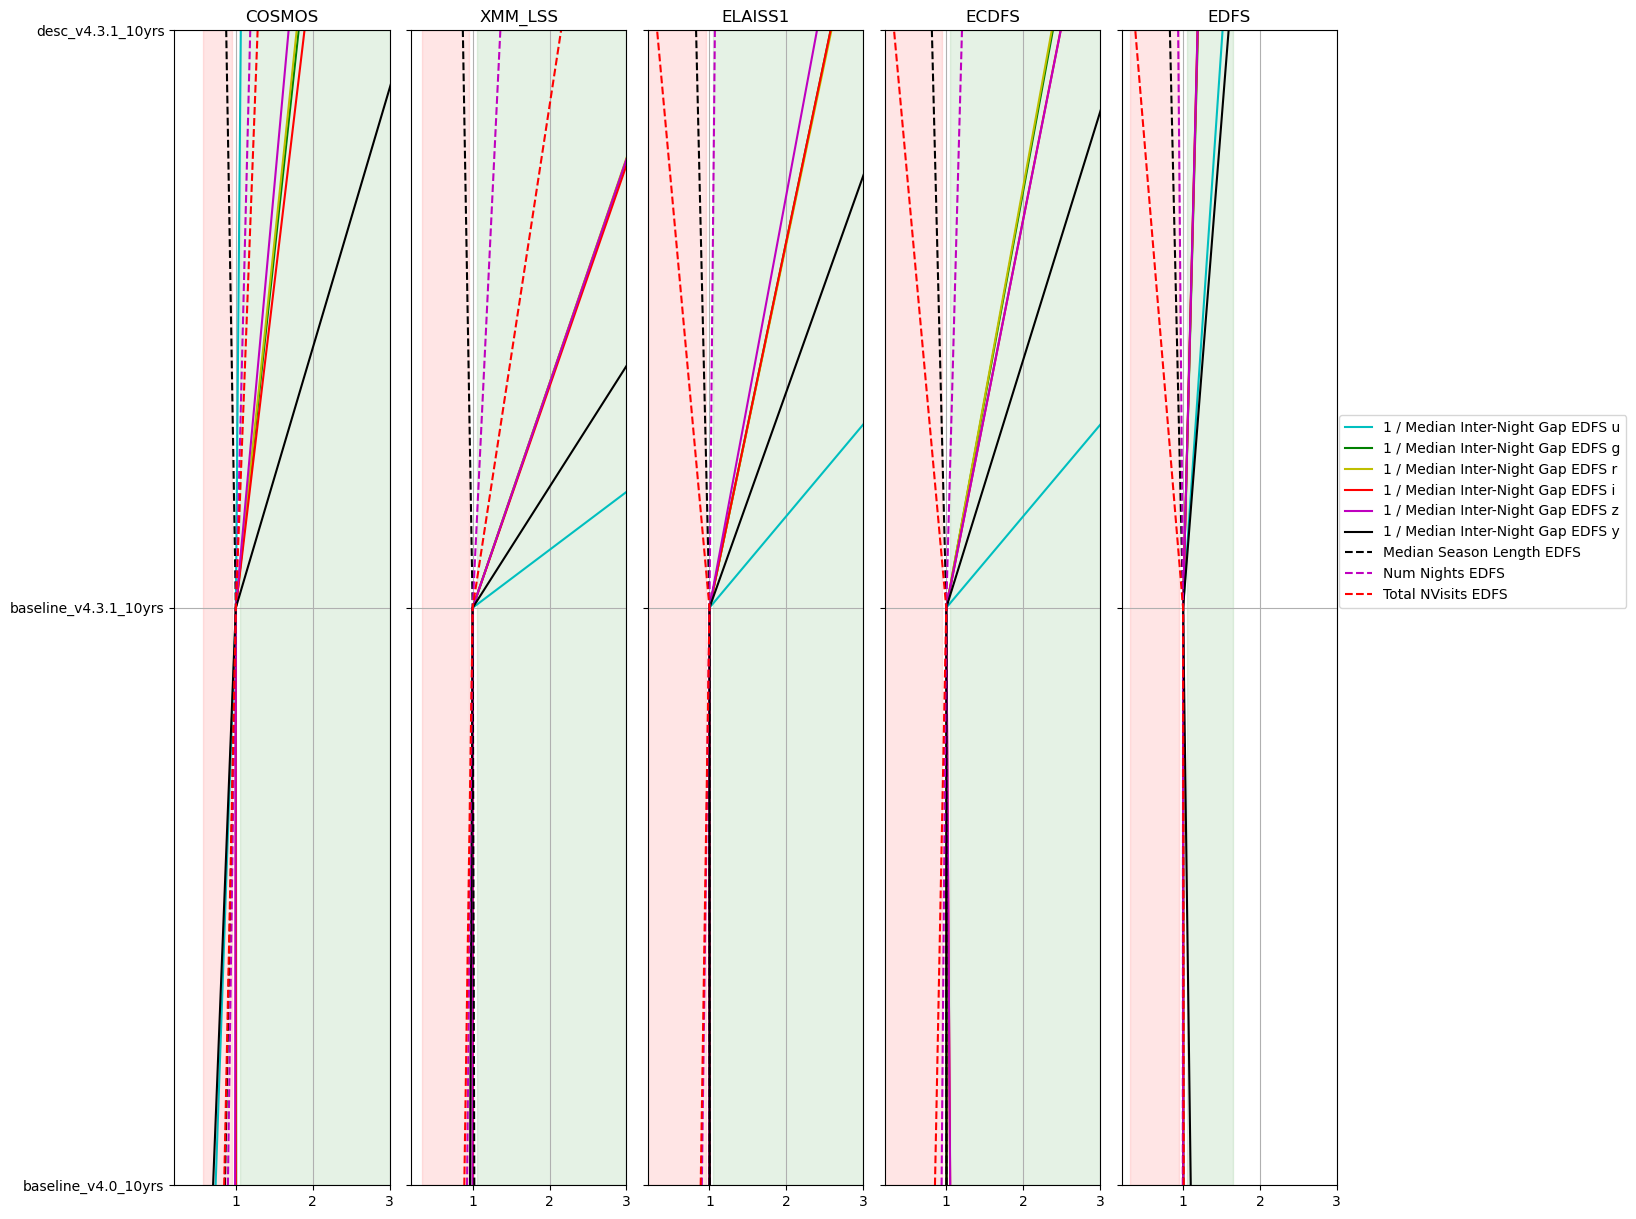

In [24]:
# Viewing this in a different way 
msub = metric_subsets.loc['DDF Cadence']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    ax.set_xlim(0.2, 3)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

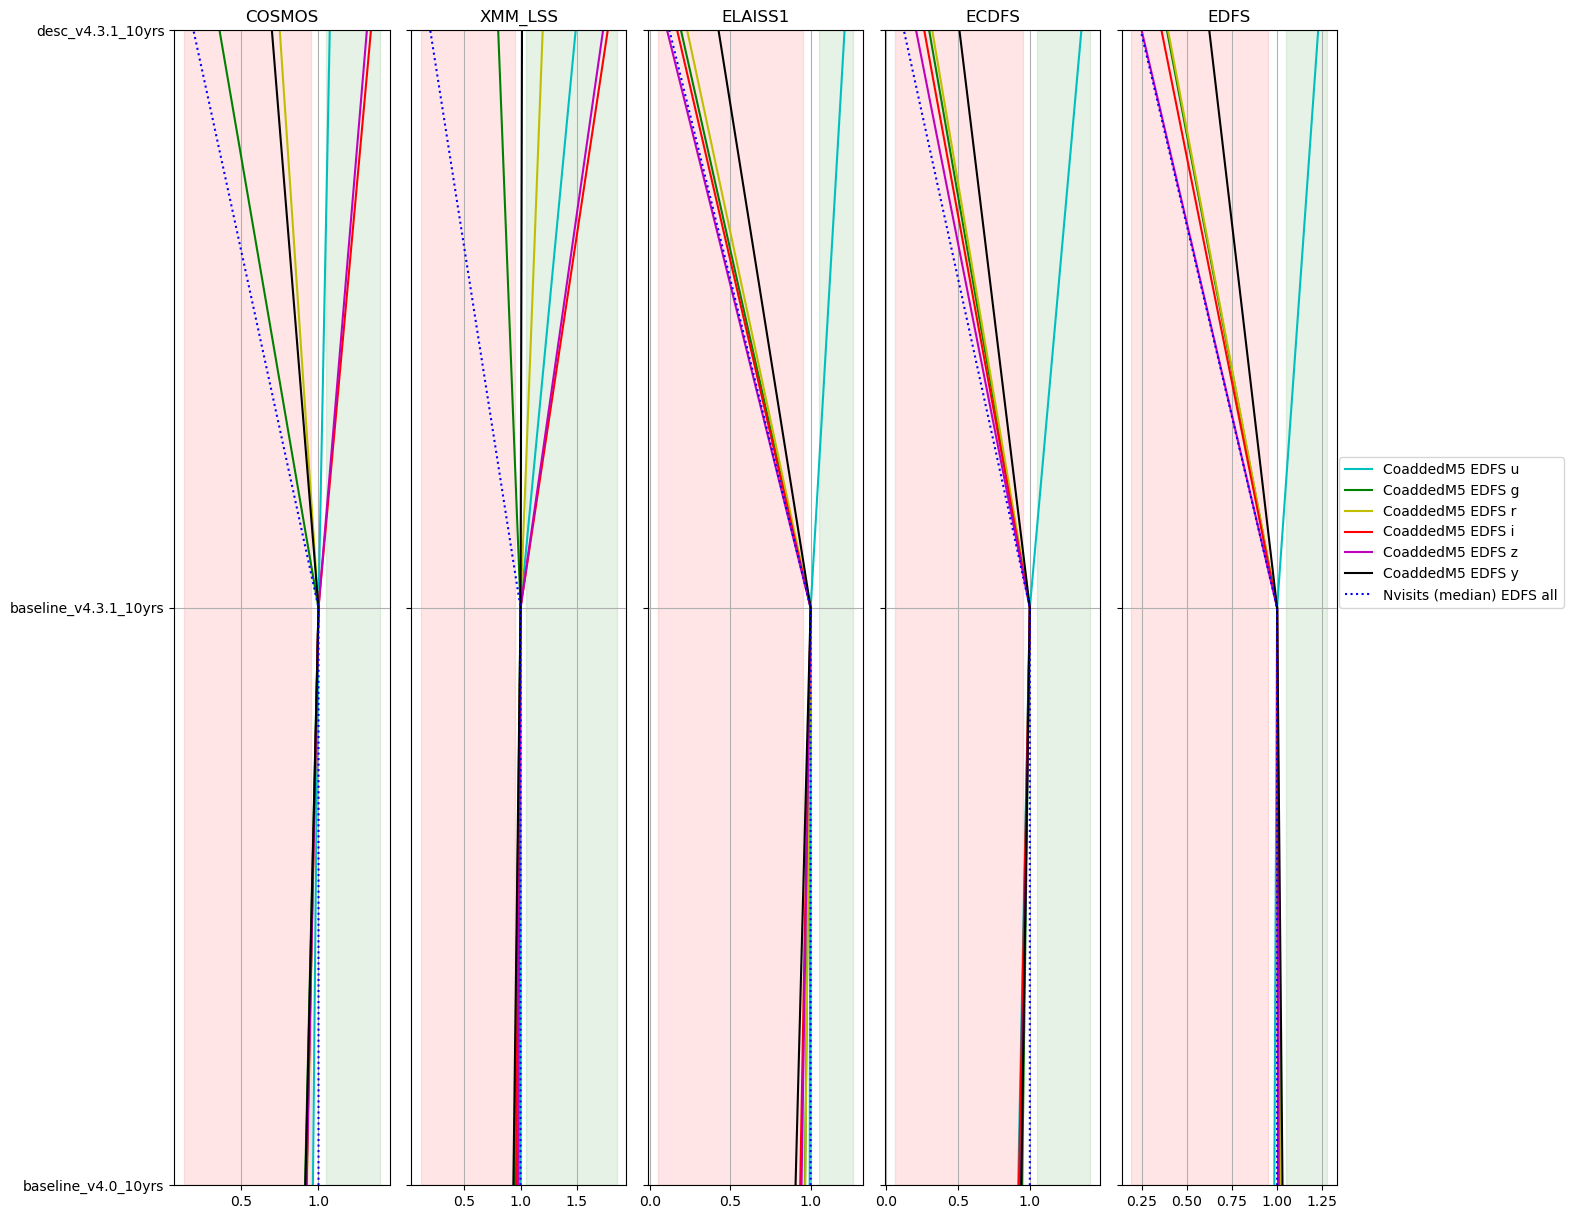

In [25]:
msub = metric_subsets.loc['DDF Depths']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    #ax.set_xlim(0.2, 1.5)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

With some insights into what's happening in the DDFs with these variations in survey strategy, let's look at the metrics more oriented toward science and see how they respond.

## AGN metrics 

Text(0.5, 1.0, 'AGN SF Error combined (2*u+g+r)')

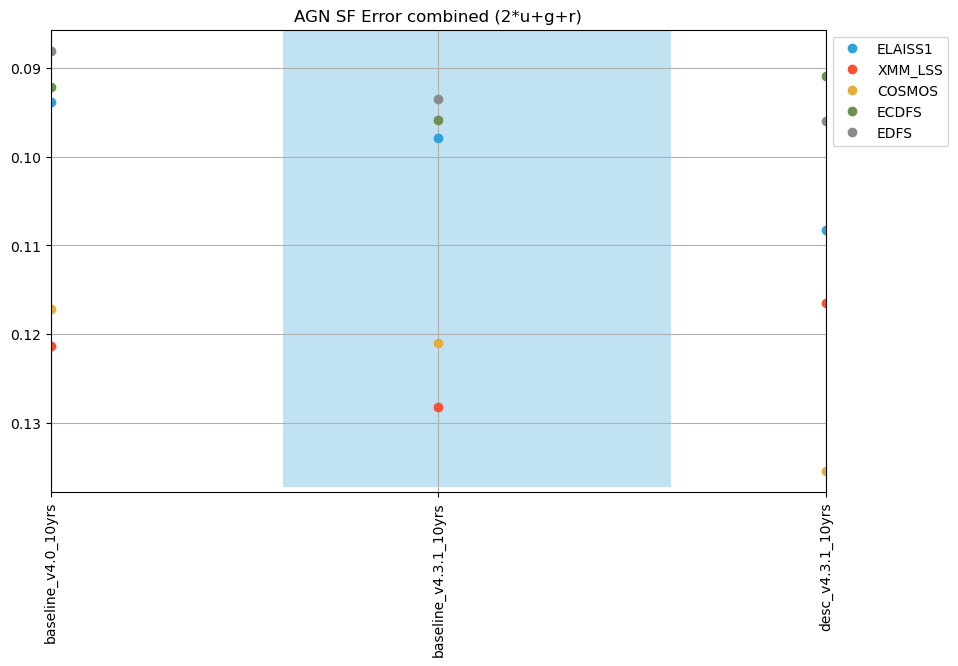

In [26]:
msub = metric_subsets.loc['AGN SF DDF'].query('not metric.str.contains("WFD")')
u = msub.iloc[::6]
g = msub.iloc[1::6]
r = msub.iloc[2::6]
ddf_names = [i.split("DD:")[1].split(' ')[0] for i in r['metric']]
agn_sf = pd.DataFrame(summaries.loc[all_runs, u['metric']].values * 2 
                      + summaries.loc[all_runs, g['metric']].values * 1 
                      + summaries.loc[all_runs, r['metric']].values * 1,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(agn_sf, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii
ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN SF Error combined (2*u+g+r)")

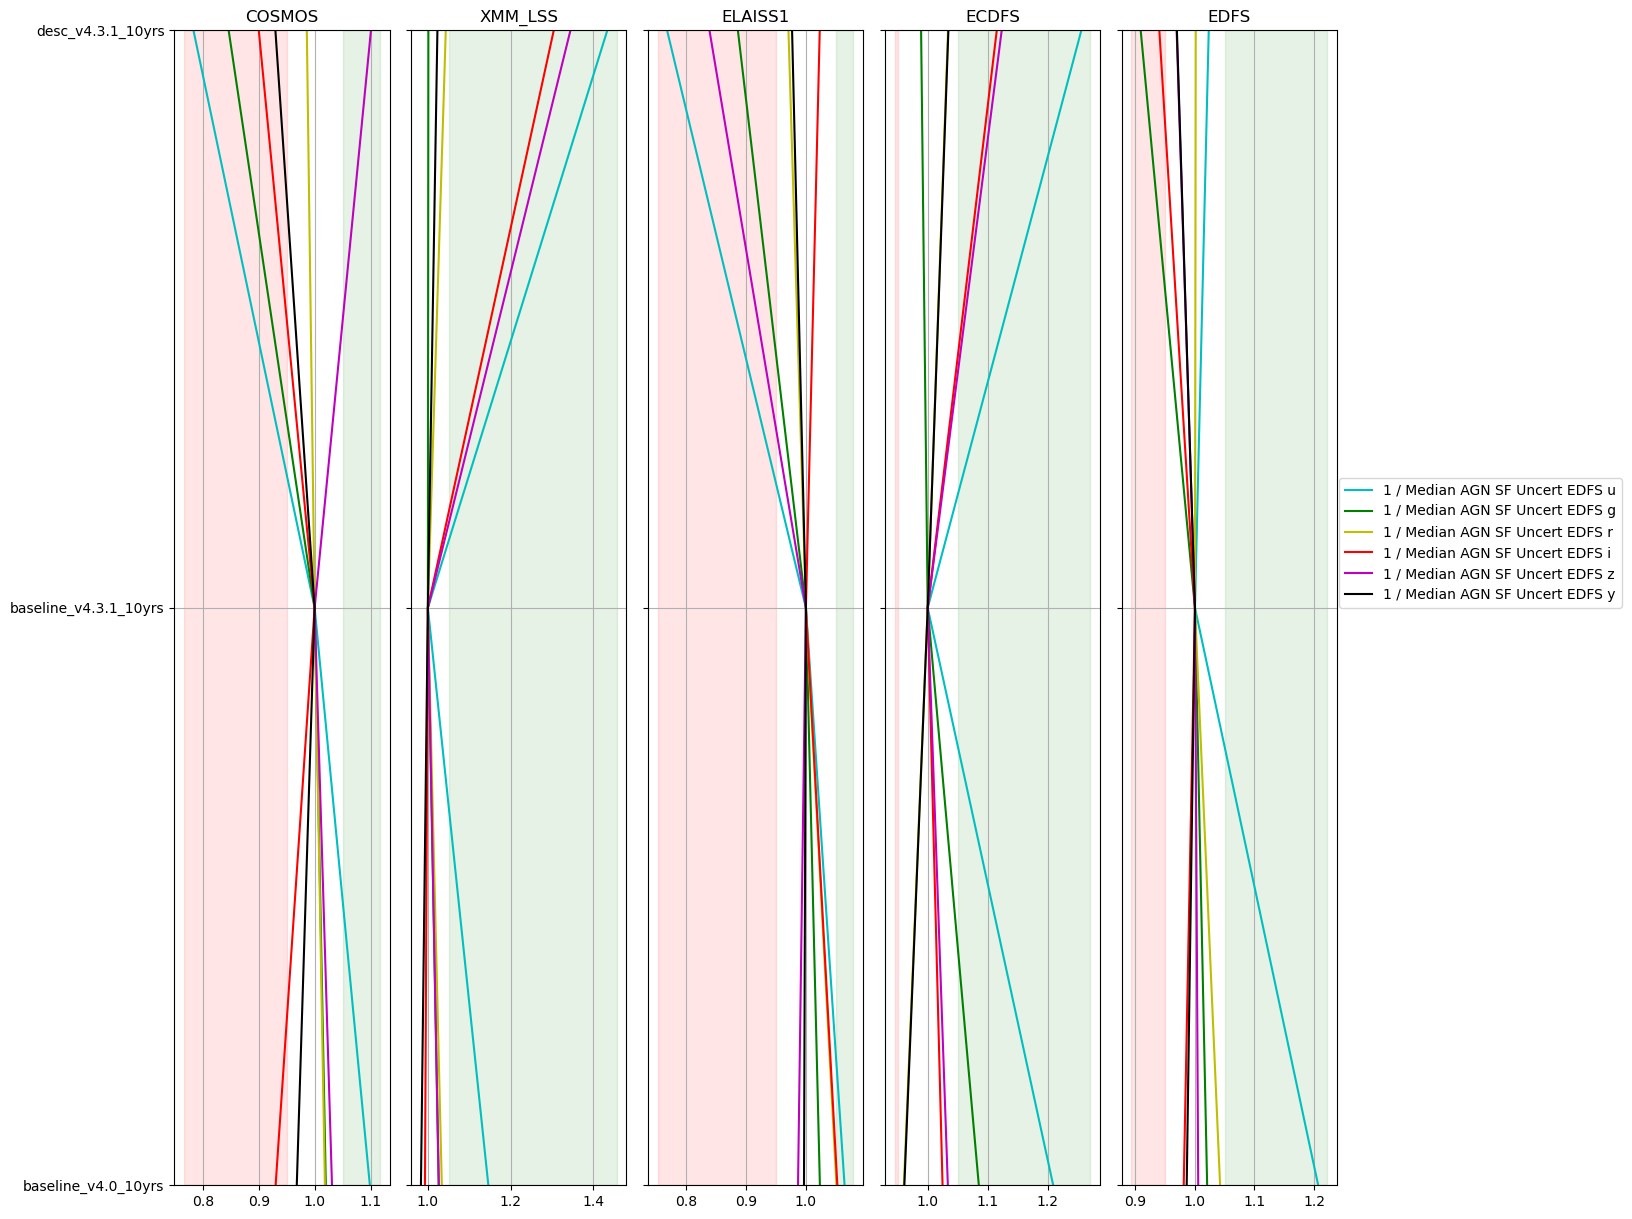

In [27]:
msub = metric_subsets.loc['AGN SF DDF']
ddfs = ['COSMOS', 'XMM_LSS', 'ELAISS1', 'ECDFS', 'EDFS']
                                                         
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(ncols=5, nrows=1, wspace=0.1)
axs = gs.subplots(sharey=True)
for dd, ax  in zip(ddfs, axs):
    msubset = msub.query('metric.str.contains(@dd)')
    fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msubset['metric']],
                                  baseline_run=baselinerun,
                                  metric_label_map=msubset['short_name'],
                                  metric_subset=msubset,
                                 horizontal_quantity='value',
                                 vertical_quantity='run',
                                 ax=ax)
    ax.get_legend().remove()
    #ax.set_xlim(0.2, 1.5)
    ax.set_title(dd)
ax.legend(loc=(1.01, 0.5))

Text(0.5, 1.0, 'AGN Timelags 100 days combined (2*u+g+r)')

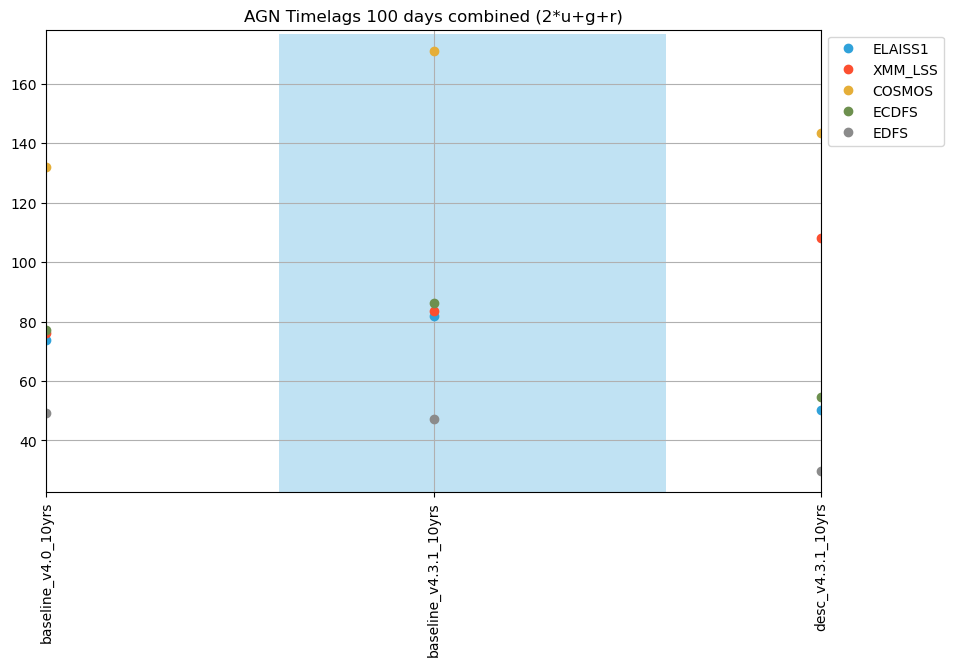

In [28]:
msub = metric_subsets.loc['AGN TimeLag 100 days DDF'].query('not metric.str.contains("WFD") and not metric.str.contains("all bands")')
u = msub.iloc[::6]
g = msub.iloc[1::6]
r = msub.iloc[2::6]
ddf_names = [i.split("DD:")[1].split(' ')[0] for i in r['metric']]
values = pd.DataFrame(summaries.loc[all_runs, u['metric']].values * 2 
                      + summaries.loc[all_runs, g['metric']].values * 1 
                      + summaries.loc[all_runs, r['metric']].values * 1,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(values, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii
# ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN Timelags 100 days combined (2*u+g+r)")

Text(0.5, 1.0, 'AGN Timelags 5 days all bands')

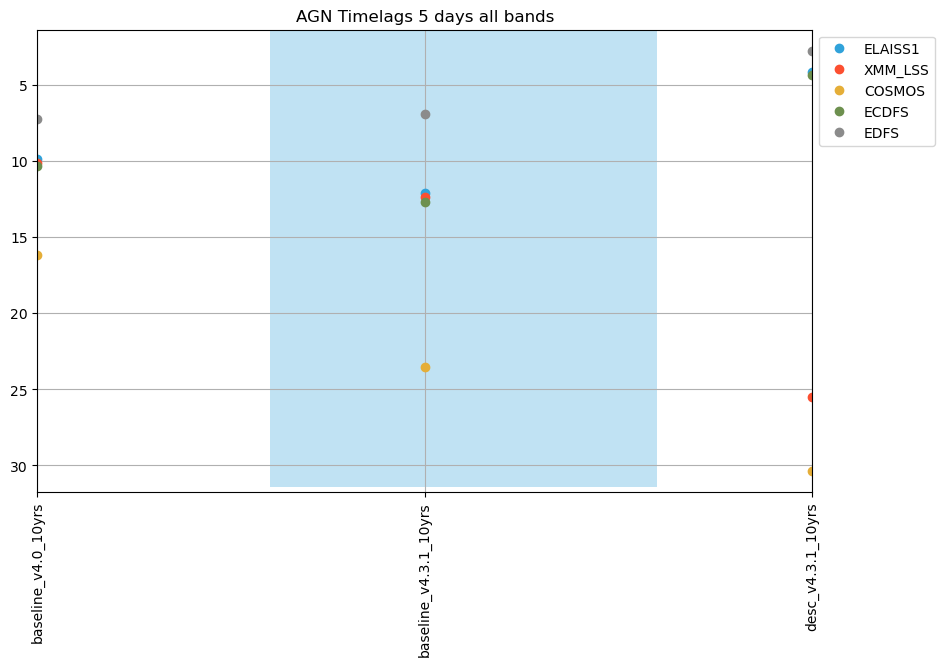

In [29]:
msub = metric_subsets.loc['AGN TimeLag 5 days DDF'].query('not metric.str.contains("WFD") and metric.str.contains("all bands")')

ddf_names = [i.split("DD:")[1].split(' ')[0] for i in msub['metric']]
values = pd.DataFrame(summaries.loc[all_runs, msub['metric']].values,
                      columns=ddf_names, index=all_runs)
fig, ax = maf.plot_run_metric(values, shade_fraction=None,
                            vertical_quantity='value', horizontal_quantity='run')
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii
ax.set_ylim(ylim[1], ylim[0])
plt.title("AGN Timelags 5 days all bands")

### SNIa metrics 

The SNIa metrics run here with an nside of 128, which is significantly higher resolution than we use for evaluating the main survey. 


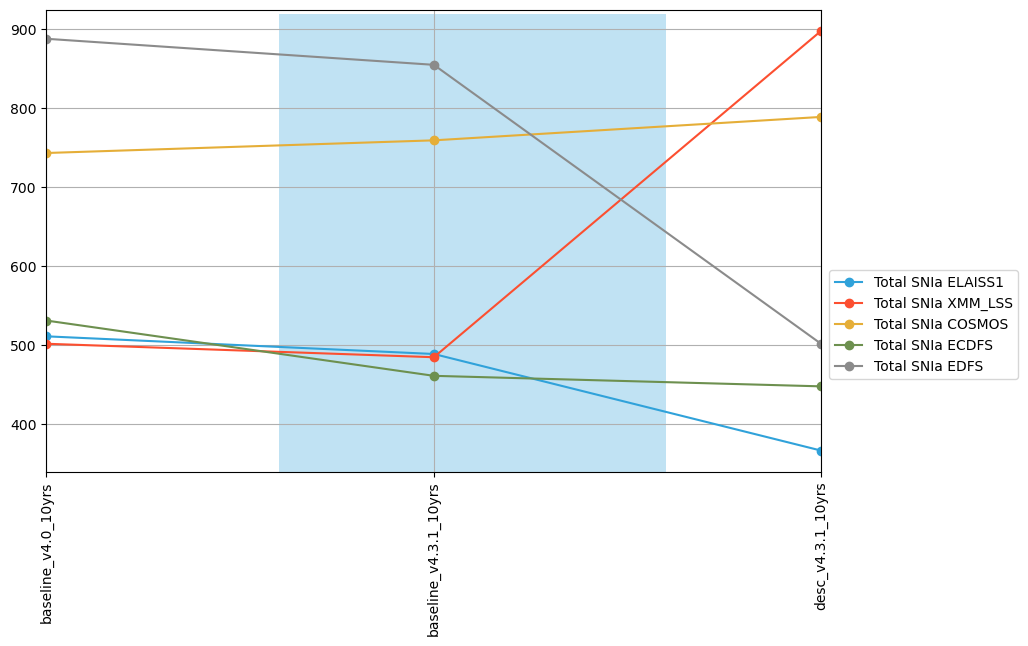

In [30]:
msub = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("Sum")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

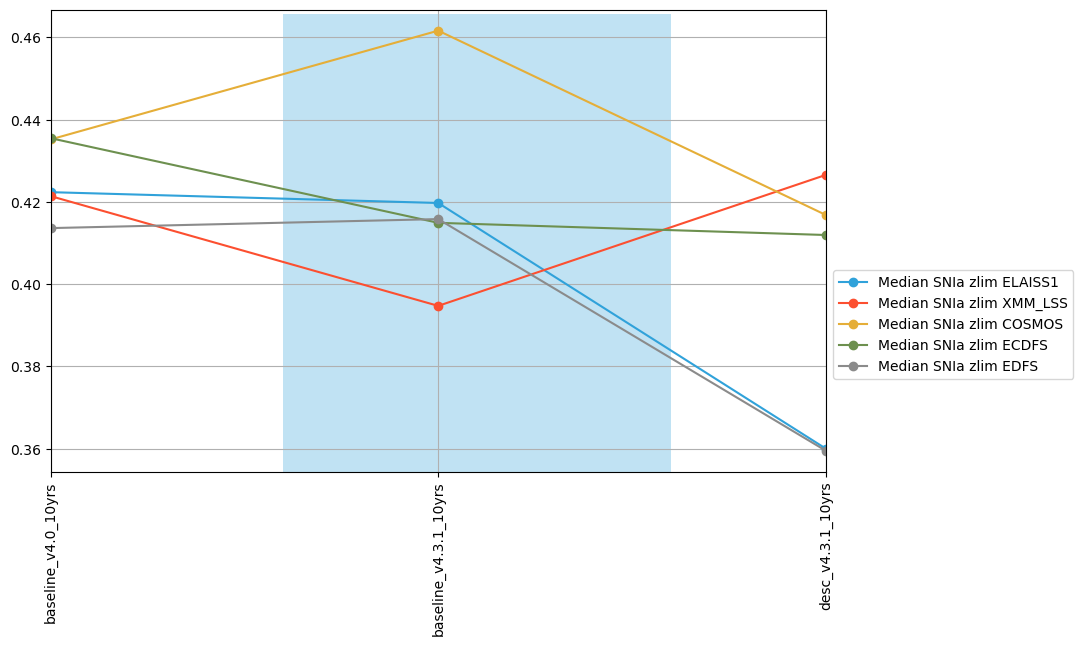

In [31]:
msub = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("zlim")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

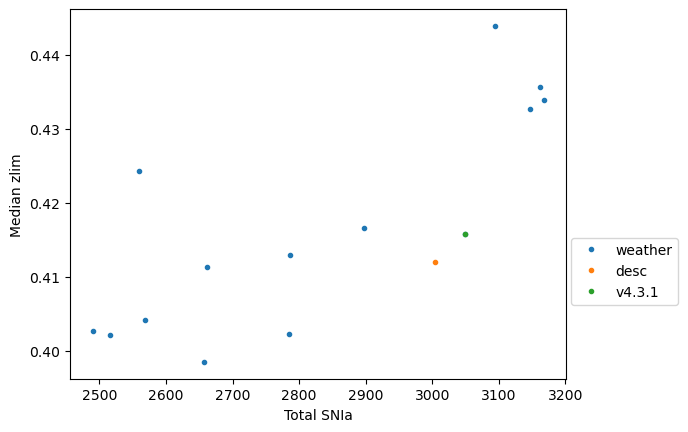

In [47]:
msub1 = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("Sum")')
msub2 = metric_subsets.loc['SNIa DDF'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("zlim")')
total_sn = summaries.loc[all_runs + weather_runs, msub1['metric']].sum(axis=1)
median_zlim = summaries.loc[all_runs + weather_runs, msub2['metric']].median(axis=1)

for fam, label in zip([weather_runs, ddf_runs, baseline], ['weather', 'desc', 'v4.3.1']):
    plt.plot(total_sn.loc[fam], median_zlim.loc[fam], marker='.', linestyle='', label=label)
plt.xlabel("Total SNIa")
plt.ylabel("Median zlim")
plt.legend(loc=(1.01, 0.2))

#### SNIa summary

No results yet.


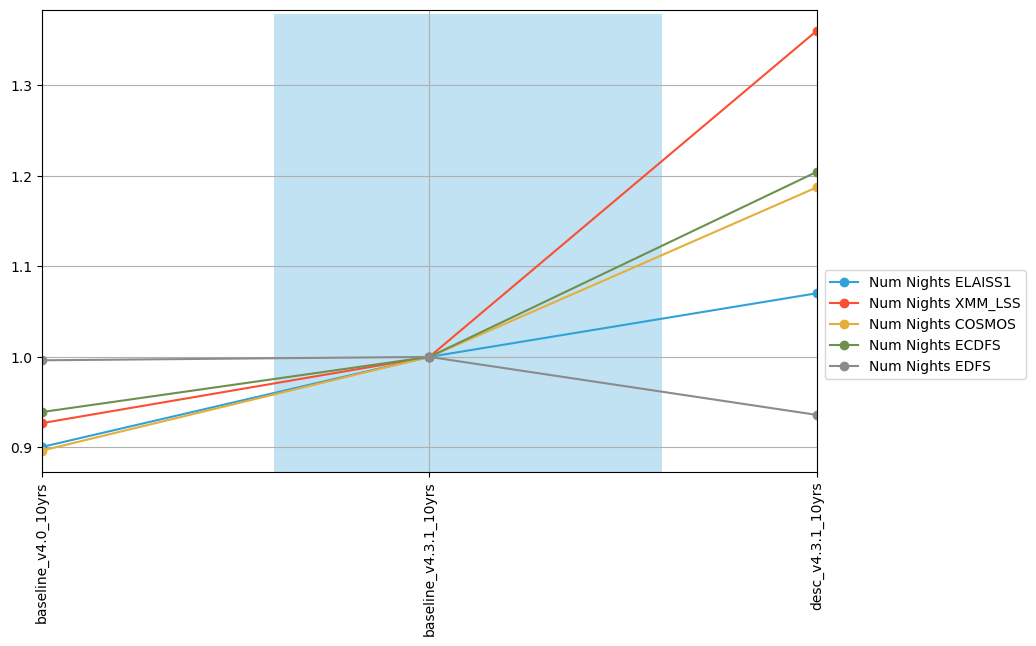

In [33]:
msub = metric_subsets.loc['DDF Cadence'].query('not metric.str.contains("WFD") and \
                                           metric.str.contains("N Unique")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

This metric DOES include the dither effects, as it's evaluated on a HealpixSubsetSlicer basis. 

## SLSN

Strongly lensed SN

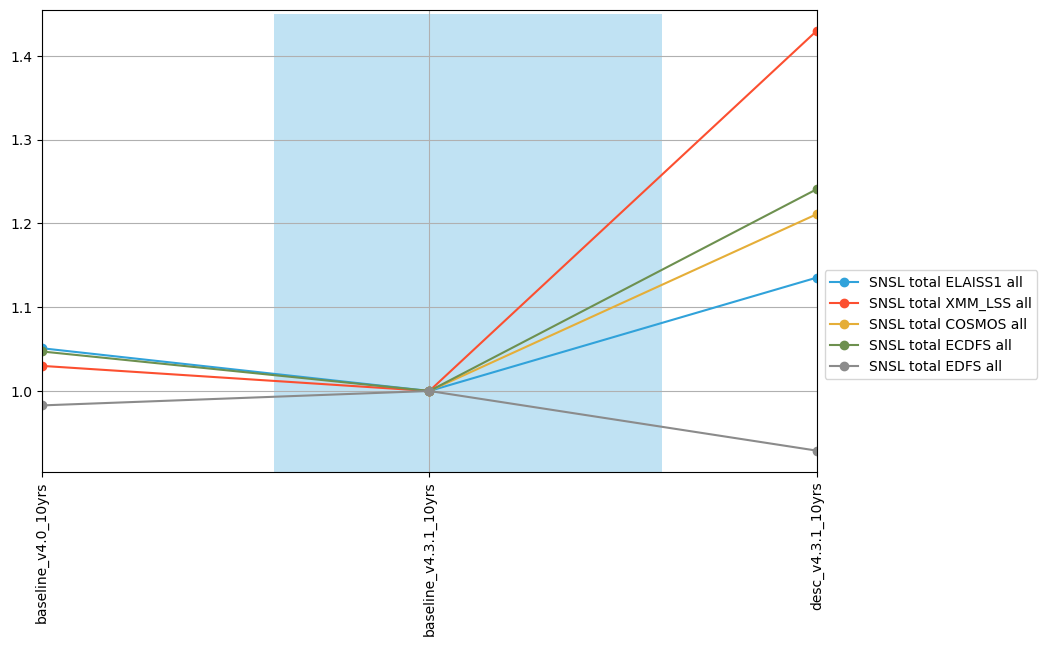

In [34]:
msub = metric_subsets.loc['SNSL DDF'].query('not metric.str.contains("WFD")')
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, msub['metric']], 
                              baseline_run=baselinerun,
                              #metric_subset=msub,
                              metric_label_map=msub['short_name'],
                              linestyles='-',
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

In [35]:
summaries.loc[all_runs, msub['metric']]

metric,Sum SNSLMetric DD:ELAISS1 all bands HealpixSubsetSlicer,Sum SNSLMetric DD:XMM_LSS all bands HealpixSubsetSlicer,Sum SNSLMetric DD:COSMOS all bands HealpixSubsetSlicer,Sum SNSLMetric DD:ECDFS all bands HealpixSubsetSlicer,Sum SNSLMetric DD:EDFS all bands HealpixSubsetSlicer
run,,,,,
baseline_v4.0_10yrs,0.015195,0.015637,NaN,0.014181,0.027155
baseline_v4.3.1_10yrs,0.014458,0.015182,0.017251,0.013542,0.027631
desc_v4.3.1_10yrs,0.016415,0.021712,0.020893,0.016805,0.025663


One of the big drivers for discovering strongly lensed supernova is having lots of opportunities to discover these rare events. Having more unique nights with observations works in favor of this metric. The 'roll' family doesn't dramatically increase this number of unique nights. 

## KNe metrics

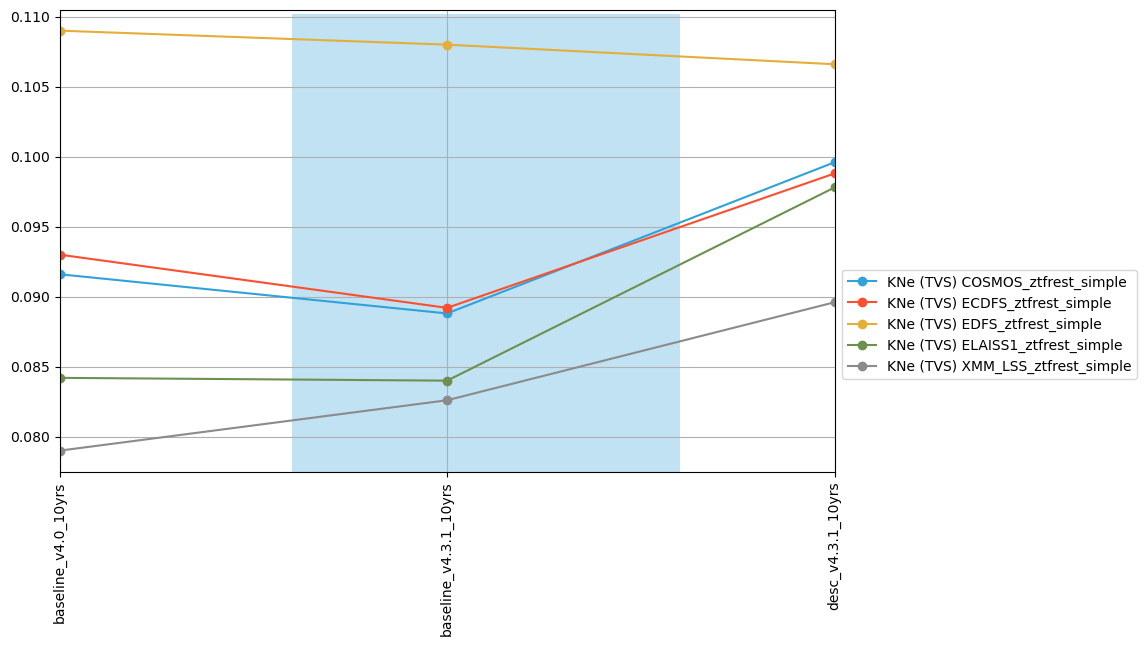

In [36]:
metrics = [m for m in summaries if 'KNe' in m and 'ztfrest_simple ' in m 
           and 'DD' in m and "Fraction detected in footprint" in m and 'WFD' not in m]
short_names = [f"KNe (TVS) {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

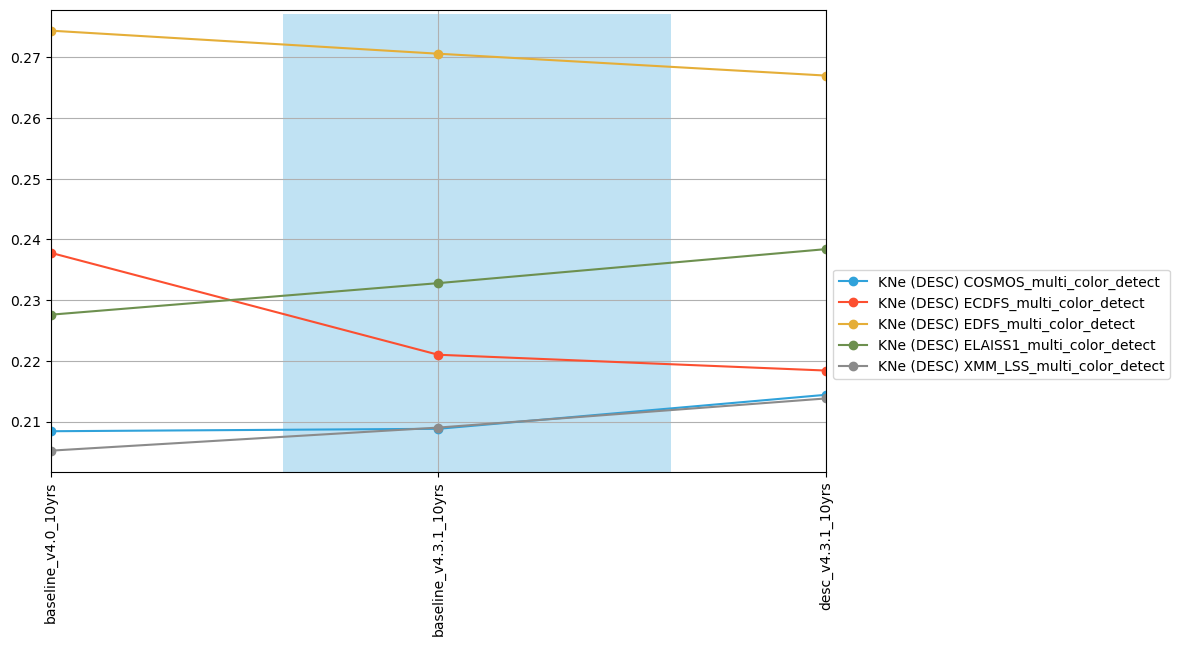

In [37]:
metrics = [m for m in summaries if 'KNe' in m  and 'multi_color_detect' in m 
           and 'DD' in m and "Fraction detected in footprint" in m and 'WFD' not in m]
short_names = [f"KNe (DESC) {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

### Weak Lensing nvisits

The weak lensing metric counts exposure time in gri or riz bands.

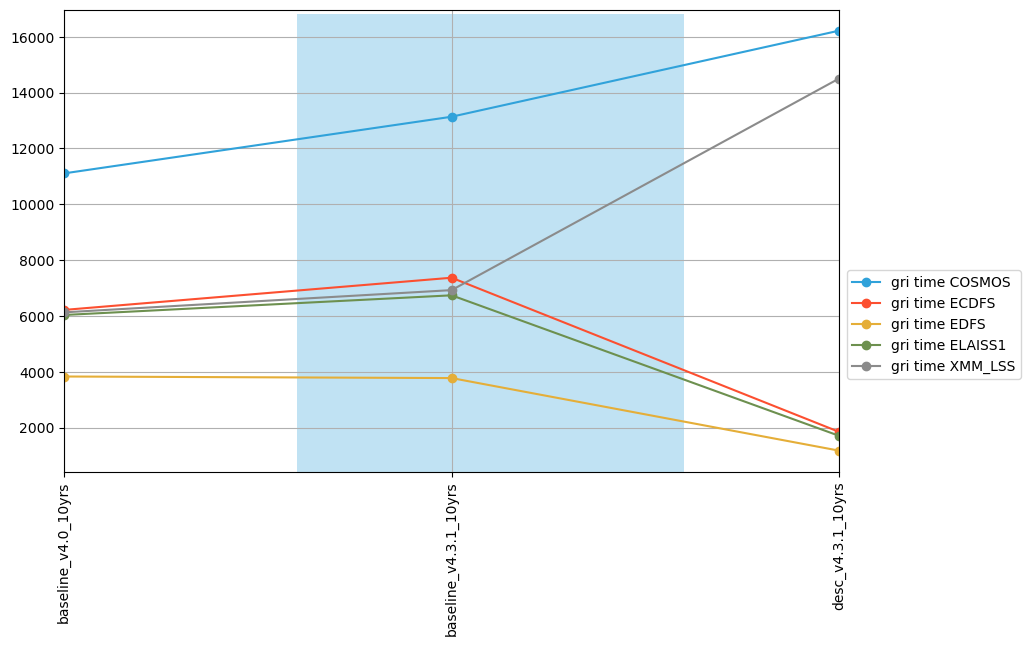

In [38]:
metrics = [m for m in summaries if "Weak" in m and "DD:" in m and "Median" in m and 'WFD' not in m and 'gri' in m]
short_names = [f"gri time {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii

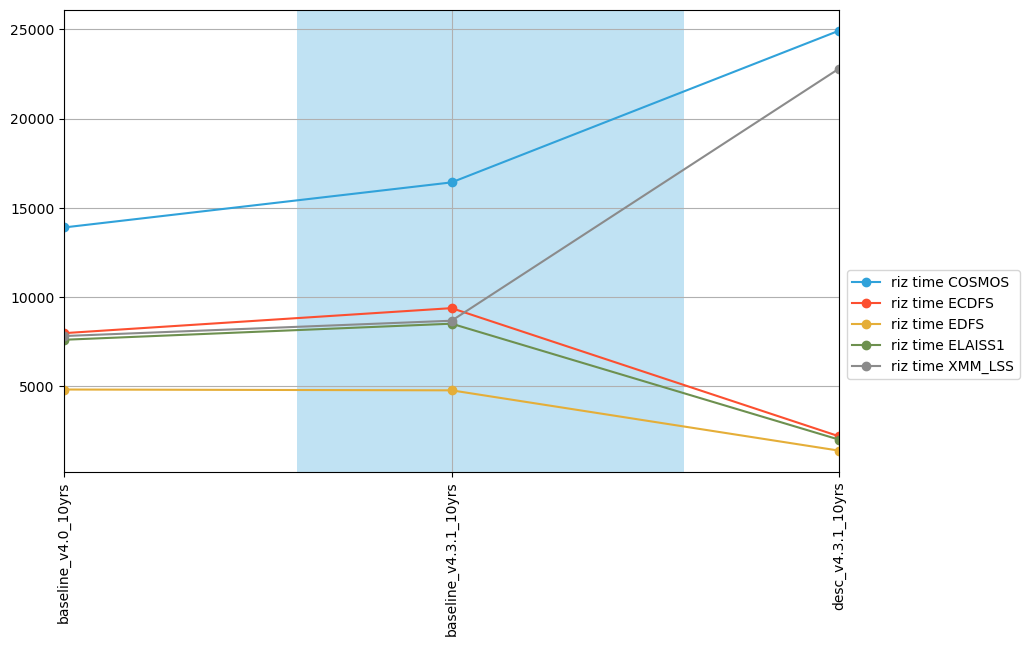

In [39]:
metrics = [m for m in summaries if "Weak" in m and "DD:" in m and "Median" in m and 'WFD' not in m and 'riz' in m]
short_names = [f"riz time {m.split('DD:')[1].split(' ')[0]}" for m in metrics]
mapper = dict(zip(metrics, short_names))
fig, ax = maf.plot_run_metric(summaries.loc[all_runs, metrics], 
                              linestyles='-',
                              metric_label_map=mapper,
                              shade_fraction=None,
                              vertical_quantity='value', horizontal_quantity='run')
plt.legend(loc=(1.01, 0.2))
ylim = ax.set_ylim()
xi = 0.6
for q in ddf_sets:
    xii = len(q) + xi
    ax.fill_betweenx(np.arange(ylim[0], ylim[1], (ylim[1]-ylim[0])/100), xi, xii, alpha=0.3)
    xi = xii